In [ ]:
import torch
import numpy as np

def fake_float32(a):

    return a


In [ ]:
import torch
import numpy as np
from lettuce.util import torch_gradient
from packaging import version

__all__ = ["Observable32", "IncompressibleKineticEnergy32",]


class Observable32:
    def __init__(self, lattice, flow):
        self.lattice = lattice
        self.flow = flow

    def __call__(self, f):
        raise NotImplementedError


class IncompressibleKineticEnergy32(Observable32):
    """Total kinetic energy of an incompressible flow."""

    def __call__(self, f):

        dx = self.flow.units.convert_length_to_pu(1.0)
        kinE = self.flow.units.convert_incompressible_energy_to_pu(torch.sum(self.lattice.incompressible_energy(f)))
        kinE *= dx ** self.lattice.D
        return kinE

In [ ]:
#def to(self, dtype=torch.float32):
#    """Konvertiert alle Tensoren im Lattice auf den gewünschten dtype."""
#    self.dtype = dtype
 #   for attr in dir(self):
 #       val = getattr(self, attr)
#        if isinstance(val, torch.Tensor):
#            setattr(self, attr, val.to(dtype))  # Alle Tensoren konvertieren

In [ ]:
"""Lattice Boltzmann Solver"""

from timeit import default_timer as timer

import numpy

import lettuce
from lettuce import (
    LettuceException, get_default_moment_transform, BGKInitialization, ExperimentalWarning, torch_gradient
)
from lettuce.util import pressure_poisson
import pickle
from copy import deepcopy
import warnings
import torch
import numpy as np

class Simulation32:
    """High-level API for simulations.

    Attributes
    ----------
    reporters : list
        A list of reporters. Their call functions are invoked after every simulation step (and before the first one).

    """

    def __init__(self, flow, lattice32, collision, streaming):
        self.flow = flow
        self.lattice = lattice32
        self.collision = collision
        self.streaming = streaming
        self.i = 0

        grid = flow.grid
        p, u = flow.initial_solution(grid)

        assert list(p.shape) == [1] + list(grid[0].shape), \
            LettuceException(f"Wrong dimension of initial pressure field. "
                             f"Expected {[1] + list(grid[0].shape)}, "
                             f"but got {list(p.shape)}.")
        assert list(u.shape) == [lattice.D] + list(grid[0].shape), \
            LettuceException("Wrong dimension of initial velocity field."
                             f"Expected {[lattice.D] + list(grid[0].shape)}, "
                             f"but got {list(u.shape)}.")
        u = lattice.convert_to_tensor(flow.units.convert_velocity_to_lu(u))
        rho = lattice.convert_to_tensor(flow.units.convert_pressure_pu_to_density_lu(p))
        self.f = lattice.equilibrium(rho, lattice.convert_to_tensor(u))

        self.reporters = []

        # Define masks, where the collision or streaming are not applied
        x = flow.grid
        self.no_collision_mask = lattice.convert_to_tensor(np.zeros_like(x[0], dtype=bool))
        no_stream_mask = lattice.convert_to_tensor(np.zeros(self.f.shape, dtype=bool))

        # Apply boundaries
        self._boundaries = deepcopy(self.flow.boundaries)  # store locally to keep the flow free from the boundary state
        for boundary in self._boundaries:
            if hasattr(boundary, "make_no_collision_mask"):
                self.no_collision_mask = self.no_collision_mask | boundary.make_no_collision_mask(self.f.shape)
            if hasattr(boundary, "make_no_stream_mask"):
                no_stream_mask = no_stream_mask | boundary.make_no_stream_mask(self.f.shape)
        if no_stream_mask.any():
            self.streaming.no_stream_mask = no_stream_mask

    def step32(self, num_steps):

        """Take num_steps stream-and-collision steps and return performance in MLUPS."""
        start = timer()
        #self.f = fake_float32(self.f)
        if self.i == 0:
            self._report()
        for _ in range(num_steps):
            self.f = self.f.to(torch.float32)
            #self.f = fake_float32(self.f)

            self.i += 1

            self.f = self.streaming(self.f)
            #self.f = fake_float32(self.f)

            # Perform the collision routine everywhere, expect where the no_collision_mask is true
            self.f = torch.where(self.no_collision_mask, self.f, self.collision(self.f))
            #self.f = fake_float32(self.f)

            for boundary in self._boundaries:
                self.f = boundary(self.f)
            #self.f = fake_float32(self.f)
            print(self.f.type)
            #self.f = self.f.to(torch.float64)
            self._report()
            print(self.f.type)




        end = timer()
        seconds = end - start
        num_grid_points = self.lattice.rho(self.f).numel()
        mlups = num_steps * num_grid_points / 1e6 / seconds



        return mlups

    def _report(self):
        for reporter in self.reporters:
            reporter(self.i, self.flow.units.convert_time_to_pu(self.i), self.f)

    def analytical_gradient_tgv(self, x, y, z):
        """Berechnet den analytischen Gradienten des Taylor-Green Vortex Geschwindigkeitsfeldes."""
        grad = torch.zeros((3, 3, *x.shape), dtype=x.dtype, device=x.device)

        # ux Ableitungen
        grad[0, 0] = torch.cos(x) * torch.cos(y) * torch.cos(z)  # ∂ux/∂x
        grad[0, 1] = -torch.sin(x) * torch.sin(y) * torch.cos(z)  # ∂ux/∂y
        grad[0, 2] = -torch.sin(x) * torch.cos(y) * torch.sin(z)  # ∂ux/∂z

        # uy Ableitungen
        grad[1, 0] = torch.sin(x) * torch.sin(y) * torch.cos(z)  # ∂uy/∂x
        grad[1, 1] = -torch.cos(x) * torch.cos(y) * torch.cos(z)  # ∂uy/∂y
        grad[1, 2] = torch.cos(x) * torch.sin(y) * torch.sin(z)  # ∂uy/∂z

        # uz = 0, also sind die Ableitungen 0
        # grad[2, 0] = grad[2, 1] = grad[2, 2] = 0 (bereits durch torch.zeros gesetzt)

        return grad

    def initialize_f_neq_float32(self, order=6):
        """Initialize the distribution function values in Float32 precision, but keep computations in Float64."""
        self.f = self.f.to(torch.float32)
        # Float32-Genauigkeit erzwingen, aber in Float64 zurückwandeln

        self.f = fake_float32(self.f)
        rho = fake_float32(self.lattice.rho(self.f))
        u = fake_float32(self.lattice.u(self.f))

        grad_u0 = fake_float32(torch_gradient(u[0], dx=1, order=order)[None, ...])
        grad_u1 = fake_float32(torch_gradient(u[1], dx=1, order=order)[None, ...])
        S = torch.cat([grad_u0, grad_u1])

        if self.lattice.D == 3:
            grad_u2 = fake_float32(torch_gradient(u[2], dx=1, order=order)[None, ...])
            S = torch.cat([S, grad_u2])

        Pi_1 = fake_float32(1.0 * self.flow.units.relaxation_parameter_lu * rho * S / self.lattice.cs ** 2)

        Q = (torch.einsum('ia,ib->iab', [self.lattice.e, self.lattice.e])
             - torch.eye(self.lattice.D, device=self.lattice.device, dtype=self.lattice.dtype) * self.lattice.cs ** 2)

        Q = fake_float32(Q)  # Fake Float32 für Q
        Pi_1_Q = fake_float32(self.lattice.einsum('ab,iab->i', [Pi_1, Q]))
        fneq = fake_float32(self.lattice.einsum('i,i->i', [self.lattice.w, Pi_1_Q]))

        # Fake Float32 für rho, u und e
        rho = fake_float32(rho)
        u = fake_float32(u)
        e = fake_float32(self.lattice.e)

        feq = fake_float32(self.lattice.equilibrium(rho, u))  # Jetzt sind alle Inputs "fake" Float32
        self.f = fake_float32(feq + fneq)  # Float64 bleibt erhalten, da fake_float32 die Präzision nur abschneidet

    def initialize_fneq_with_analytical_gradient(self, mach):

        """Initialisiert f basierend auf dem analytischen Gradienten des TGV."""
        L = 2 * torch.pi
        N = self.f.shape[1]  # Annahme: f hat die Form [q, Nx, Ny, Nz]

        # Erstelle Gitterpunkte mit "endpoint=False"
        dx = L / N
        x = torch.arange(0, L, dx, device=self.f.device) + dx / 2
        y = torch.arange(0, L, dx, device=self.f.device) + dx / 2
        z = torch.arange(0, L, dx, device=self.f.device) + dx / 2

        # Erstelle das Gitter
        X, Y, Z = torch.meshgrid(x, y, z, indexing='ij')

        # Analytisches Geschwindigkeitsfeld
        rho = self.lattice.rho(self.f)  # Dichte ist typischerweise 1 im TGV

        u = self.lattice.u(self.f)

        # Berechne den analytischen Gradienten
        grad_u = (self.analytical_gradient_tgv(X, Y, Z)) * mach * 1 / torch.sqrt(
            torch.tensor(3.0, device=X.device)) * torch.pi * 2 / N

        # Berechnung von Pi_1 und fneq
        Pi_1 = 1.0 * self.flow.units.relaxation_parameter_lu * rho * grad_u / self.lattice.cs ** 2
        Q = (torch.einsum('ia,ib->iab', [self.lattice.e, self.lattice.e])
             - torch.eye(self.lattice.D, device=self.lattice.device, dtype=self.lattice.dtype) * self.lattice.cs ** 2)
        Pi_1_Q = self.lattice.einsum('ab,iab->i', [Pi_1, Q])
        fneq = self.lattice.einsum('i,i->i', [self.lattice.w, Pi_1_Q])

        # Berechnung von feq und f
        feq = self.lattice.equilibrium(rho, u)
        self.f = feq + fneq


In [ ]:
class BGKCollision32:
    def __init__(self, lattice32, tau, force=None):
        self.force = force
        self.lattice = lattice32
        self.tau = tau

    def __call__(self, f):
        f = fake_float32(f)
        rho = fake_float32(self.lattice.rho(f))
        u_eq = 0 if self.force is None else self.force.u_eq(f)
        u = fake_float32(self.lattice.u(f) + u_eq)
        feq = fake_float32(self.lattice.equilibrium(rho, u))
        Si = 0 if self.force is None else self.force.source_term(u)
        return f - fake_float32(1.0 / self.tau * (f - feq) + Si)

In [ ]:
"""
Streaming Step
"""

import torch
import numpy as np
__all__ = ["StandardStreaming32"]

class StandardStreaming32:
    """Standard Streaming step on a regular grid.

    Attributes
    ----------
    no_stream_mask : torch.Tensor
        Boolean mask with the same shape as the distribution function f.
        If None, stream all (also around all boundaries).
    """

    def __init__(self, lattice):
        self.lattice = lattice
        self._no_stream_mask = None

    @property
    def no_stream_mask(self):
        return self._no_stream_mask

    @no_stream_mask.setter
    def no_stream_mask(self, mask):
        self._no_stream_mask = mask

    def __call__(self, f):
        for i in range(1, self.lattice.Q):
            if self.no_stream_mask is None:
                f[i] = self._stream(f, i)
            else:
                new_fi = self._stream(f, i)
                f[i] = torch.where(self.no_stream_mask[i], f[i], new_fi)
        return f

    def _stream(self, f, i):
        return torch.roll(f[i], shifts=tuple(self.lattice.stencil.e[i]), dims=tuple(np.arange(self.lattice.D)))


In [ ]:
"""
Stencils and Lattices.

A Stencil, like the D1Q3 class, provides particle velocities (e), weights (w), and speeds of sound.
Velocities and weights are stored as numpy arrays.

In contrast, the Lattice lives on the Device (usually a GPU) and its vectors are stored as torch tensors.
Its stencil is still accessible trough Lattice.stencil.
"""

import warnings
import numpy as np
import torch

from lettuce.util import LettuceException
from lettuce.equilibrium import QuadraticEquilibrium

__all__ = ["Lattice32"]


class Lattice32:


    def __init__(self, stencil, device, dtype=torch.float):
        self.stencil = stencil
        self.device = device
        self.dtype = dtype
        self.e = self.convert_to_tensor(stencil.e)
        self.w = self.convert_to_tensor(stencil.w)
        self.cs = self.convert_to_tensor(stencil.cs)
        self.equilibrium = QuadraticEquilibrium(self)

    def __str__(self):
        return f"Lattice (stencil {self.stencil.__name__}; device {self.device}; dtype {self.dtype})"

    @property
    def D(self):
        return self.stencil.e.shape[1]

    @property
    def Q(self):
        return self.stencil.e.shape[0]

    def convert_to_tensor(self, array):

        def is_bool_array(it):
            return (isinstance(it, torch.BoolTensor) or
                    (isinstance(it, np.ndarray) and it.dtype in [bool, np.uint8]))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            if is_bool_array(array):
                return torch.tensor(array, device=self.device, dtype=torch.bool)
            else:
                return torch.tensor(array, device=self.device, dtype=self.dtype)

    @classmethod
    def convert_to_numpy(cls, tensor):
        return tensor.detach().cpu().numpy()

    def rho(self, f):
        """density"""
        return torch.sum(f, dim=0)[None, ...]

    def j(self, f):
        """momentum"""
        return self.einsum("qd,q->d", [self.e, f])

    def u(self, f):
        """velocity"""
        return self.j(f) / self.rho(f)

    def incompressible_energy(self, f):
        """incompressible kinetic energy"""
        return 0.5 * self.einsum("d,d->", [self.u(f), self.u(f)])

    def incompressbile_energy_wo_boundary(self, f):

        f_wo_boundary=f[1:-1,1:-1]
        return 0.5 * self.einsum("d,d->", [self.u(f_wo_boundary), self.u(f_wo_boundary)])
    def entropy(self, f):
        """entropy according to the H-theorem"""
        f_log = -torch.log(self.einsum("q,q->q", [f, 1 / self.w]))
        return self.einsum("q,q->", [f, f_log])

    def pseudo_entropy_global(self, f):
        """pseudo_entropy derived by a Taylor expansion around the weights"""
        f_w = self.einsum("q,q->q", [f, 1 / self.w])
        return self.rho(f) - self.einsum("q,q->", [f, f_w])

    def pseudo_entropy_local(self, f):
        """pseudo_entropy derived by a Taylor expansion around the local equilibrium"""
        f_feq = f / self.equilibrium(self.rho(f), self.u(f))
        return self.rho(f) - self.einsum("q,q->", [f, f_feq])

    def shear_tensor(self, f):
        """computes the shear tensor of a given f in the sense Pi_{\alpha \beta} = f_i * e_{i \alpha} * e_{i \beta}"""
        shear = self.einsum("qa,qb->qab", [self.e, self.e])
        shear = self.einsum("q,qab->ab", [f, shear])
        return shear

    def mv(self, m, v):
        """matrix-vector multiplication"""
        return self.einsum("ij,j->i", [m, v])

    def einsum(self, equation, fields, **kwargs):
        """Einstein summation on local fields."""
        input, output = equation.split("->")
        inputs = input.split(",")
        for i, inp in enumerate(inputs):
            if len(inp) == len(fields[i].shape):
                pass
            elif len(inp) == len(fields[i].shape) - self.D:
                inputs[i] += "..."
                if not output.endswith("..."):
                    output += "..."
            else:
                raise LettuceException("Bad dimension.")
        equation = ",".join(inputs) + "->" + output
        return torch.einsum(equation, fields, **kwargs)


In [16]:
class SimulationFlex:
    def __init__(self, flow, collision, streaming, init_dtype=torch.float32, sim_dtype=torch.float64):
        # Wähle Lattice für die Initialisierung
        if init_dtype == torch.float32:
            self.lattice_init = lt.Lattice(lt.D3Q27, device="cuda", dtype=torch.float32)
        else:
            self.lattice_init = lt.Lattice(lt.D3Q27, device="cuda", dtype=torch.float64)

        # Wähle Lattice für die Simulation
        if sim_dtype == torch.float32:
            self.lattice_sim = lt.Lattice(lt.D3Q27, device="cuda", dtype=torch.float32)
        else:
            self.lattice_sim = lt.Lattice(lt.D3Q27, device="cuda", dtype=torch.float64)

        self.flow = flow
        self.collision = collision
        self.streaming = streaming
        self.i = 0

        grid = flow.grid
        p, u = flow.initial_solution(grid)

        u = self.lattice_init.convert_to_tensor(flow.units.convert_velocity_to_lu(u))
        rho = self.lattice_init.convert_to_tensor(flow.units.convert_pressure_pu_to_density_lu(p))
        self.f = self.lattice_init.equilibrium(rho, u)

        self.reporters = []

        # Define masks, where the collision or streaming are not applied
        x = flow.grid
        self.no_collision_mask = self.lattice_sim.convert_to_tensor(np.zeros_like(x[0], dtype=bool))
        no_stream_mask = self.lattice_sim.convert_to_tensor(np.zeros(self.f.shape, dtype=bool))

        # Apply boundaries
        self._boundaries = deepcopy(self.flow.boundaries)
        for boundary in self._boundaries:
            if hasattr(boundary, "make_no_collision_mask"):
                self.no_collision_mask = self.no_collision_mask | boundary.make_no_collision_mask(self.f.shape)
            if hasattr(boundary, "make_no_stream_mask"):
                no_stream_mask = no_stream_mask | boundary.make_no_stream_mask(self.f.shape)
        if no_stream_mask.any():
            self.streaming.no_stream_mask = no_stream_mask

    def initialize_f_neq(self, order=6):
        """Initialisiert f_neq mit `lattice_init`, hält aber Berechnung mit `lattice_sim`."""
        self.f = self.f.to(self.lattice_init.dtype)  # Initialisierung in init_dtype
        rho = self.lattice_init.rho(self.f)
        u = self.lattice_init.u(self.f)

        grad_u0 = torch_gradient(u[0], dx=1, order=order)[None, ...]
        grad_u1 = torch_gradient(u[1], dx=1, order=order)[None, ...]
        S = torch.cat([grad_u0, grad_u1])

        if self.lattice_init.D == 3:
            grad_u2 = torch_gradient(u[2], dx=1, order=order)[None, ...]
            S = torch.cat([S, grad_u2])

        Pi_1 = 1.0 * self.flow.units.relaxation_parameter_lu * rho * S / self.lattice_init.cs ** 2
        Q = (torch.einsum('ia,ib->iab', [self.lattice_init.e, self.lattice_init.e])
             - torch.eye(self.lattice_init.D, device=self.lattice_init.device, dtype=self.lattice_init.dtype) * self.lattice_init.cs ** 2)
        Pi_1_Q = self.lattice_init.einsum('ab,iab->i', [Pi_1, Q])
        fneq = self.lattice_init.einsum('i,i->i', [self.lattice_init.w, Pi_1_Q])

        feq = self.lattice_init.equilibrium(rho, u)
        self.f = feq + fneq

        # Nach der Initialisierung zu sim_dtype wechseln
        self.f = self.f.to(self.lattice_sim.dtype)

    def step(self, num_steps):
        """Simuliert num_steps Schritte mit `lattice_sim`."""
        self.f = self.f.to(self.lattice_sim.dtype)  # Wechsel zu sim_dtype für die Simulation
        start = timer()
        if self.i == 0:
            self._report()
        for _ in range(num_steps):
            self.f = self.streaming(self.f)
            self.f = torch.where(self.no_collision_mask, self.f, self.collision(self.f))
            for boundary in self._boundaries:
                self.f = boundary(self.f)
            self.i += 1
            self._report()
        end = timer()

        seconds = end - start
        num_grid_points = self.lattice_sim.rho(self.f).numel()
        mlups = num_steps * num_grid_points / 1e6 / seconds

        return mlups

    def _report(self):
        for reporter in self.reporters:
            reporter(self.i, self.flow.units.convert_time_to_pu(self.i), self.f)



🔹 Starte Simulation: Init torch.float32, Sim torch.float64 (init32_sim64)
steps     time     IncompressibleKineticEnergy
⚠ Fehler beim Speichern von init32_sim64

🔹 Starte Simulation: Init torch.float64, Sim torch.float32 (init64_sim32)
steps     time     IncompressibleKineticEnergy
⚠ Fehler beim Speichern von init64_sim32

🔹 Starte Simulation: Init torch.float64, Sim torch.float64 (init64_sim64_tau32)
steps     time     IncompressibleKineticEnergy
⚠ Fehler beim Speichern von init64_sim64_tau32

🔹 Starte Simulation: Init torch.float32, Sim torch.float64 (init32_sim64_tau32)
steps     time     IncompressibleKineticEnergy
⚠ Fehler beim Speichern von init32_sim64_tau32


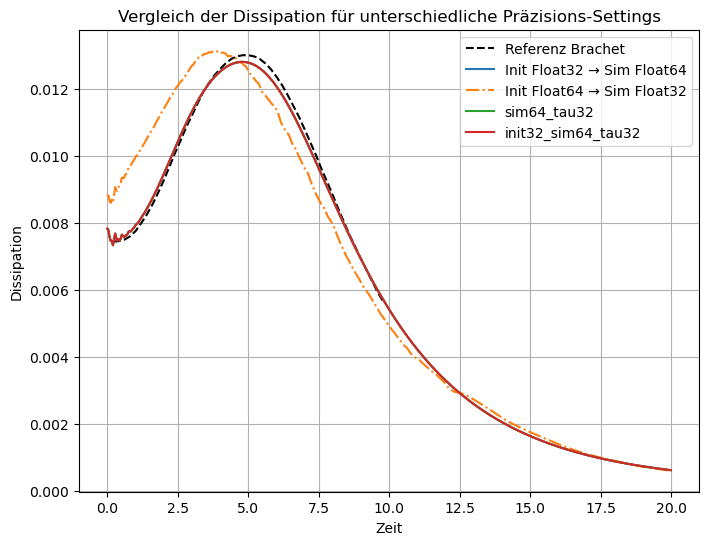

In [18]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import csv
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter

# 🔹 Argumente einlesen
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--resolution", type=int, default=32)
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=200)
parser.add_argument("--tmax", type=int, default=20)
parser.add_argument("--Re", type=int, default=100)
parser.add_argument("--collision_operator", type=str, default="BGK")
parser.add_argument("--Precision", type=str, default="Double")
parser.add_argument("--Mach", type=float, default=0.005)
args, unknown = parser.parse_known_args()
args = vars(args)

# 🔹 Simulationsparameter setzen
Re = args["Re"]
csvdir = args["csvdir"]
res = args["resolution"]
tmax = args["tmax"]
collision_operator = args["collision_operator"]
Mach = args["Mach"]

# 🔹 Präzision setzen
dtype_double = torch.float64
dtype_single = torch.float32

# 🔹 Funktion zur Durchführung einer Simulation
def run_simulation(init_dtype, sim_dtype, label, collision_operator):
    print(f"\n🔹 Starte Simulation: Init {init_dtype}, Sim {sim_dtype} ({label})")

    lattice_init = lt.Lattice(lt.D3Q27, device="cuda", dtype=init_dtype)
    lattice_sim = lt.Lattice(lt.D3Q27, device="cuda", dtype=sim_dtype)

    flow = lt.TaylorGreenVortex3D(resolution=res, reynolds_number=Re, mach_number=Mach, lattice=lattice_init)
    if collision_operator == "BGK-tau32":
        import math
        collision = BGKCollision32(lattice_sim, tau=math.floor(flow.units.relaxation_parameter_lu * 10**7) / 10**7)
    if collision_operator == "BGK":
        collision = BGKCollision32(lattice_sim, tau=flow.units.relaxation_parameter_lu)
    elif collision_operator == "KBC":
        collision = lt.KBCCollision3D(lattice_sim, tau=flow.units.relaxation_parameter_lu)

    streaming = StandardStreaming32(lattice_sim)
    simulation = SimulationFlex(flow=flow, collision=collision, streaming=streaming, init_dtype=init_dtype, sim_dtype=sim_dtype)

    interval_out = int((flow.units.convert_time_to_lu(tmax)) / 500)
    Energy = lt.IncompressibleKineticEnergy(lattice_sim, flow)
    reporter = lt.ObservableReporter(Energy, interval=interval_out, out=None)
    simulation.reporters.append(reporter)

    # 🔹 Simulation durchführen
    steps = int(flow.units.convert_time_to_lu(tmax))
    simulation.initialize_f_neq()
    mlups = simulation.step(num_steps=steps)

    # 🔹 Energie-Dissipation berechnen
    energy = np.array(simulation.reporters[0].out)
    dEdt = np.zeros(len(energy[:, 2]))
    dt = energy[1, 1] - energy[0, 1]
    nmax = len(energy[:, 2])

    for i in range(len(energy[:, 2])):
        if i == 0:
            dEdt[i] = (energy[1, 2] - energy[0, 2]) / dt
        elif i == 1:
            dEdt[i] = (energy[2, 2] - energy[0, 2]) / (2 * dt)
        elif i == 2:
            dEdt[i] = (1 / 12 * energy[0, 2] - 2 / 3 * energy[1, 2] + 2 / 3 * energy[3, 2] - 1 / 12 * energy[4, 2]) / dt
        elif i >= (nmax - 3):
            if i == (nmax - 3):
                dEdt[i] = (1 / 12 * energy[nmax - 5, 2] - 2 / 3 * energy[nmax - 4, 2] + 2 / 3 * energy[nmax - 2, 2] - 1 / 12 * energy[nmax - 1, 2]) / dt
            elif i == (nmax - 2):
                dEdt[i] = (energy[nmax - 1, 2] - energy[nmax - 3, 2]) / (2 * dt)
            elif i == (nmax - 1):
                dEdt[i] = (energy[nmax - 1, 2] - energy[nmax - 2, 2]) / dt
        elif i < (nmax - 3):
            dEdt[i] = (-1 / 60 * energy[i - 3, 2] + 3 / 20 * energy[i - 2, 2] - 3 / 4 * energy[i - 1, 2] + 3 / 4 * energy[i + 1, 2] - 3 / 20 * energy[i + 2, 2] + 1 / 60 * energy[i + 3, 2]) / dt

    dissipationEkin = np.array([energy[:, 1], -dEdt / (np.pi * 2) ** 3])

    # 🔹 Speichern der Dissipation
    try:
        with open(f"{csvdir}DissipationEkin_{label}.csv", "w", newline="") as file:
            writer = csv.writer(file)
            writer.writerows(dissipationEkin)
    except:
        print(f"⚠ Fehler beim Speichern von {label}")

    return dissipationEkin

# 🔹 Simulation 1: Float32 Init, Float64 Simulation
dissipation_32_64 = run_simulation(dtype_single, dtype_double, "init32_sim64", "BGK")

# 🔹 Simulation 2: Float64 Init, Float32 Simulation
dissipation_64_32 = run_simulation(dtype_double, dtype_single, "init64_sim32", "BGK")

dissipation_64_64_tau32 = run_simulation(dtype_double, dtype_double, "init64_sim64_tau32", "BGK-tau32")

dissipation_32_64_tau32 = run_simulation(dtype_single, dtype_double, "init32_sim64_tau32", "BGK-tau32")

with open(csvdir + 'init32sim64.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipation_32_64)
with open(csvdir + 'init64sim32.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipation_64_32)
    with open(csvdir + 'init64sim64tau32.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipation_64_64_tau32)
    with open(csvdir + 'init32sim64tau32.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipation_32_64_tau32)





# 🔹 Referenzdaten laden
Rey = Re
if Rey == 100 or Rey == 800:
    csv_file_path = f'/home/ben/Schreibtisch/Enstropy Brachet/Brachet/Brachet_1983_tgv3d_enstrophy_Re{Rey}.csv'
    csv_data = []
    with open(csv_file_path, 'r') as file:
        csv_reader = csv.reader(file, delimiter=';')
        for row in csv_reader:
            csv_data.append(row)
    csv_data = np.array(csv_data, dtype=float).T
elif Rey == 1600:
    csv_file_path = f"/home/ben/Schreibtisch/Referenz/Re{Rey}.csv"
    csv_data = np.genfromtxt(csv_file_path, delimiter=";", dtype=str)
    csv_data = np.char.replace(csv_data, ',', '.').astype(float).T
else:
    csv_data = np.loadtxt(f"/home/ben/Schreibtisch/Referenz/Re{Rey}.csv", delimiter=",")

# 🔹 Dissipation plotten
plt.figure(figsize=(8, 6))
plt.plot(csv_data[0, :], csv_data[1, :], label="Referenz Brachet", linestyle="--", color="black")
plt.plot(dissipation_32_64[0, :], dissipation_32_64[1, :], label="Init Float32 → Sim Float64", linestyle="-")
plt.plot(dissipation_64_32[0, :], dissipation_64_32[1, :], label="Init Float64 → Sim Float32", linestyle="-.")
plt.plot(dissipation_64_64_tau32[0,:], dissipation_64_64_tau32[1,:], label = "sim64_tau32")
plt.plot(dissipation_32_64_tau32[0,:], dissipation_32_64_tau32[1,:], label = "init32_sim64_tau32")

plt.xlabel("Zeit")
plt.ylabel("Dissipation")
plt.legend()
plt.title("Vergleich der Dissipation für unterschiedliche Präzisions-Settings")
plt.grid(True)
plt.show()
